In [1]:
from neo4j import GraphDatabase

def get_neo4j_driver(uri, user, password) -> GraphDatabase.driver:
    return GraphDatabase.driver(uri, auth=(user, password))

uri = "neo4j+s://9d1381c2.databases.neo4j.io:7687"  # my uri
user = "Wesley"  # my user name
password = "Xlbabv969."  # my password
driver = get_neo4j_driver(uri, user, password)

In [2]:
pip install graphdatascience


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
from neo4j import GraphDatabase
import pandas as pd


def get_data(tx):
    query = """
    MATCH (ir:IngredientResearch)-[:HAS_TASTE_PROFILE]->(tp:TasteProfile)
    RETURN ir.ingredient_name AS IngredientName, tp AS TasteProfileProperties
    """
    result = tx.run(query)
    
    data = []
    for record in result:
        
        properties = dict(record["TasteProfileProperties"])
        properties["IngredientName"] = record["IngredientName"]
        data.append(properties)
    return data

with driver.session() as session:
    data = session.read_transaction(get_data)


df = pd.DataFrame(data)



C:\Users\Wesle\AppData\Local\Temp\ipykernel_19888\180540489.py:21: DeprecationWarning: read_transaction has been renamed to execute_read
  data = session.read_transaction(get_data)


In [5]:
import plotly.express as px

aroma_counts = df['aroma'].value_counts()

fig = px.bar(aroma_counts, x=aroma_counts.index, y=aroma_counts.values,
             title="Frequency of Aroma Descriptions",
             labels={'x': 'Aroma Types', 'y': 'Count'})
fig.show()


In [6]:
fig = px.scatter_matrix(df,
                        dimensions=['flavour_release', 'volatility', 'mouthfeel', 'texture'],
                        color='IngredientName',
                        title='Scatter Matrix of Various Taste Profile Properties')
fig.show()

c:\ProgramData\anaconda3\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [7]:
from neo4j import GraphDatabase
import pandas as pd


def get_data(tx):
    query = """
    MATCH (p:Product)-[:HAS_RECIPE]->(r:Recipe)-[:HAS_TASTE_PROFILE]->(tp:TasteProfile)
    RETURN p.name AS ProductName, properties(tp) AS TasteProfileProperties
    """
    result = tx.run(query)
    
    data = []
    for record in result:
        profile = record["TasteProfileProperties"]
        profile["ProductName"] = record["ProductName"]
        data.append(profile)
    return data

with driver.session() as session:
    data = session.read_transaction(get_data)


df = pd.DataFrame(data)


C:\Users\Wesle\AppData\Local\Temp\ipykernel_19888\4042909409.py:20: DeprecationWarning:

read_transaction has been renamed to execute_read



In [8]:
import plotly.express as px


flavour_interaction_counts = df['Flavour_Interaction'].value_counts()

fig = px.bar(flavour_interaction_counts, x=flavour_interaction_counts.index, y=flavour_interaction_counts.values,
             title="Frequency of Flavour Interaction Descriptions",
             labels={'x': 'Flavour Interaction Types', 'y': 'Count'})
fig.show()

In [9]:
import plotly.express as px

fig = px.scatter_matrix(df,
                        dimensions=['Flavour_Release', 'Aroma'],
                        color='ProductName',
                        title='Scatter Matrix of Various Taste Profile Properties Related to Ingredients')
fig.show()

c:\ProgramData\anaconda3\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [10]:
print(df.columns)  

Index(['Interaction', 'Culinary_Applications', 'Aftertaste', 'Mouthfeel',
       'Flavour_Interaction', 'Texture', 'id', 'Visual_Description', 'Flavour',
       'Sensitivity_Variations', 'Volatility', 'Pairing_Suggestions',
       'Flavour_Release', 'Aroma', 'ProductName'],
      dtype='object')


In [12]:
from neo4j import GraphDatabase
import pandas as pd

def get_data(tx):
    query = """
    MATCH (p:Product)-[:HAS_RECIPE]->(:Recipe)-[:HAS_TASTE_PROFILE]->(tp:TasteProfile)
    WHERE p.name CONTAINS 'Noodle' OR p.name CONTAINS 'Noodles'
    RETURN p.name AS ProductName, properties(tp) AS TasteProfileProperties
    """
    result = tx.run(query)
 
    data = []
    for record in result:
        product_data = record["TasteProfileProperties"]
        product_data["ProductName"] = record["ProductName"]
        data.append(product_data)
    return data


with driver.session() as session:
    data = session.execute_read(get_data)


driver.close()


df = pd.DataFrame(data)


cols = ['ProductName'] + [col for col in df if col != 'ProductName']
df = df[cols]


df.style.hide(axis='index')  


ProductName,Interaction,Culinary_Applications,Aftertaste,Mouthfeel,Flavour_Interaction,Texture,id,Visual_Description,Flavour,Sensitivity_Variations,Volatility,Pairing_Suggestions,Flavour_Release,Aroma
Indomie Mi Goreng Instant Noodles,"The noodles, seasoning powder, seasoning oil, sweet soy sauce, chilli sauce, and fried onion all interact with other ingredients to create new flavor profiles.","The noodles can be used in a variety of dishes, such as stir-fries, soups, and salads. The seasoning powder, seasoning oil, sweet soy sauce, chilli sauce, and fried onion can be used as seasonings or condiments.","The noodles have a savory aftertaste, the seasoning powder has a sweet and savory aftertaste, the seasoning oil has a savory aftertaste, the sweet soy sauce has a sweet and savory aftertaste, and the chilli sauce has a spicy aftertaste. The fried onion has a sweet and savory aftertaste.","The noodles are smooth, the seasoning powder is grainy, the seasoning oil is slippery, the sweet soy sauce is sticky, and the chilli sauce is smooth. The fried onion is crunchy.","The noodles, seasoning powder, seasoning oil, sweet soy sauce, chilli sauce, and fried onion all interact to create a complex and layered flavor profile.","The noodles are chewy, the seasoning powder is powdery, the seasoning oil is oily, the sweet soy sauce is syrupy, and the chilli sauce is saucy. The fried onion is crispy.",863858658f47c2c97599b343779dab2f313a843f63384b2e611fa21c8261ad46_taste_0,"The noodles are golden yellow, the seasoning powder is dark brown, the seasoning oil is light yellow, the sweet soy sauce is dark brown, and the chilli sauce is red. The fried onion is golden brown.","The noodles have a savory flavor, the seasoning powder is sweet and savory, the seasoning oil is savory, the sweet soy sauce is sweet and savory, and the chilli sauce is spicy and savory. The fried onion is sweet and savory.",The sensitivity to the flavors may vary depending on the individual's taste preferences and dietary habits.,The flavors are not very volatile and do not dissipate quickly.,"The noodles pair well with vegetables, meat, and seafood. The seasoning powder, seasoning oil, sweet soy sauce, chilli sauce, and fried onion can be paired with a variety of dishes to add flavor.",The flavors are released immediately upon eating and linger in the mouth for a while.,"The noodles have a savory aroma, the seasoning powder has a sweet and savory aroma, the seasoning oil has a savory aroma, the sweet soy sauce has a sweet and savory aroma, and the chilli sauce has a spicy aroma. The fried onion has a sweet and savory aroma."
Maggi 2 Minute Chicken Flavour Instant Noodles,"The noodles interact well with other ingredients, absorbing flavours and adding texture.","The noodles can be used as a base for a variety of dishes, such as stir-fries, soups, and curries.","The noodles leave a savoury aftertaste in the mouth, thanks to the flavour enhancers and spices.","The noodles have a smooth mouthfeel, with a slight graininess from the wheat flour. The flavour mix sachet adds a savoury coating to the noodles.","The flavour of the noodles is enhanced by the flavour mix sachet, which contains a blend of spices, flavour enhancers, and colours.",The noodles are thin and have a springy texture. They are easy to chew and do not become mushy when overcooked.,aae0f720bcbe04d20af0c295bd8df8031e5c29738cff3b6a63c990b905af0e57_taste_0,"The noodles are yellow in colour, indicating the use of turmeric as a colourant. The chicken flavour mix sachet is powdery and light yellow in colour.","The noodles have a savoury chicken flavour, thanks to the flavour enhancers and spices in the flavour mix sachet. The flavour is well-rounded and not overly salty.","The flavour and aroma of the noodles may be perceived differently by different individuals, depending on their sensitivity to flavour enhancers and spices.",The aroma of the noodles is volatile and dissipates quickly after cooking.,"The noodles pa

In [13]:
def get_high_protein_products(driver):
    query = """
    MATCH (p:Product)-[:HAS_RECIPE]->(:Recipe)-[:HAS_NUTRITIONAL_INFO]->(n:NutritionalInformation)
    WHERE n.Carbohydrate IS NOT NULL AND n.Dietary_Fibre IS NOT NULL AND n.Fat_Total IS NOT NULL AND n.Protein IS NOT NULL
    WITH p, n,
    TOFLOAT(SUBSTRING(n.Carbohydrate, 0, SIZE(n.Carbohydrate)-1)) AS carbs,
    TOFLOAT(SUBSTRING(n.Dietary_Fibre, 0, SIZE(n.Dietary_Fibre)-1)) AS fibre,
    TOFLOAT(SUBSTRING(n.Fat_Total, 0, SIZE(n.Fat_Total)-1)) AS fat,
    TOFLOAT(SUBSTRING(n.Protein, 0, SIZE(n.Protein)-1)) AS protein
    WITH p.name AS product_name, protein / (carbs + fibre + fat + protein) AS ratio
    WHERE ratio > 0.2
    RETURN product_name, ratio
    """
    with driver.session() as session:
        result = session.run(query)
        return [{"product_name": record["product_name"], "ratio": record["ratio"]} for record in result]


C:\Users\Wesle\AppData\Local\Temp\ipykernel_19888\536956285.py:14: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.



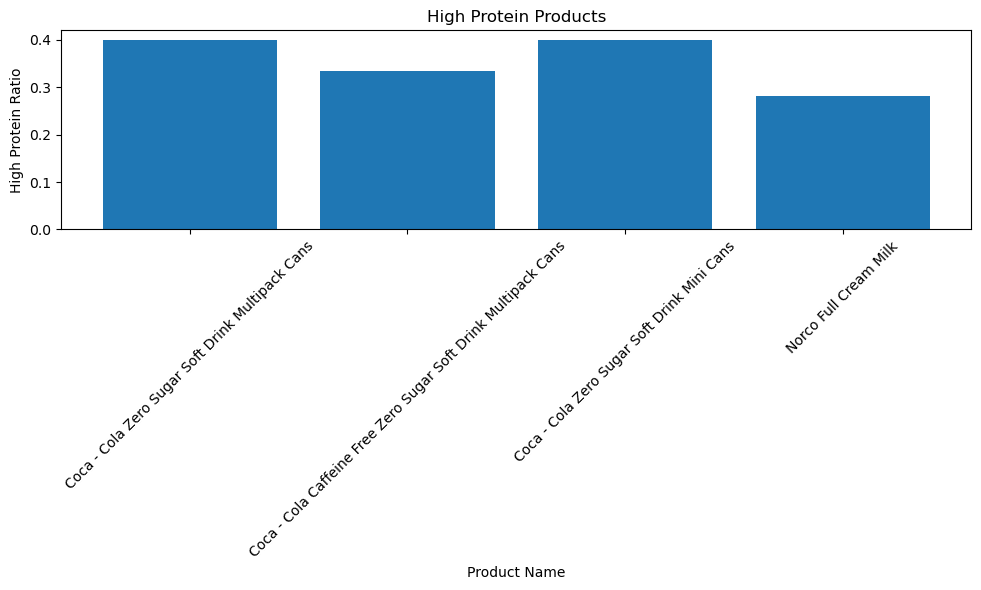

In [14]:
import matplotlib.pyplot as plt

# Get High Protein Products
high_protein_products = get_high_protein_products(driver)

# Extract data
names = [item["product_name"] for item in high_protein_products]
ratios = [item["ratio"] for item in high_protein_products]

# visualisation
plt.figure(figsize=(10, 6))
plt.bar(names, ratios)
plt.xlabel('Product Name')
plt.ylabel('High Protein Ratio')
plt.title('High Protein Products')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
def create_high_protein_relationship(driver):
    query = """
    MERGE (hp:HighProtein {name: "HighProtein"})
    MATCH (p:Product)-[:HAS_RECIPE]->(:Recipe)-[:HAS_NUTRITIONAL_INFO]->(n:NutritionalInformation)
    WHERE n.Carbohydrate IS NOT NULL AND n.Dietary_Fibre IS NOT NULL AND n.Fat_Total IS NOT NULL AND n.Protein IS NOT NULL
    WITH p, n,
    TOFLOAT(SUBSTRING(n.Carbohydrate, 0, SIZE(n.Carbohydrate)-1)) AS carbs,
    TOFLOAT(SUBSTRING(n.Dietary_Fibre, 0, SIZE(n.Dietary_Fibre)-1)) AS fibre,
    TOFLOAT(SUBSTRING(n.Fat_Total, 0, SIZE(n.Fat_Total)-1)) AS fat,
    TOFLOAT(SUBSTRING(n.Protein, 0, SIZE(n.Protein)-1)) AS protein
    WITH p, protein / (carbs + fibre + fat + protein) AS ratio
    WHERE ratio > 0.2
    MERGE (p)-[:High_Protein {protein_ratio: ratio}]->(hp)
    """
    with driver.session() as session:
        session.run(query)
